In [4]:
#import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import time

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import time
elapsed_times_wtih_cache= []
elapsed_times_with_no_cache = []
peaks_with_cache = []
peaks_with_no_cache = []
#model_names = ["microsoft/Phi-3-mini-4k-instruct","mistralai/Mistral-Nemo-Instruct-2407","adamo1139/aya-expanse-8b-ungated","Qwen/Qwen2.5-7B-Instruct"]
model_names = ["microsoft/Phi-3-mini-4k-instruct","adamo1139/aya-expanse-8b-ungated","Qwen/Qwen2.5-7B-Instruct"]
# adamo1139/aya-expanse-8b-ungated
for model_name in model_names:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(
        model_name, 
        torch_dtype=torch.float16, 
        device_map="auto"
        # NO trust_remote_code=True — uses std modeling_phi3.py [web:96][web:108]
    )
    prompt = "I like working out because"
    inputs = tokenizer(prompt, return_tensors="pt", padding=True).to(model.device)
    for use_cache in [True, False]:
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        start_time = time.time()
        _ = model.generate(**inputs, max_new_tokens=50, use_cache=use_cache)
        elapsed = time.time() - start_time
        peak = torch.cuda.max_memory_allocated() / 1e9
        print(f"use_cache={use_cache}: {elapsed:.1f}s ({peak:.2f}GB peak)")
        if use_cache:
            elapsed_times_wtih_cache.append(elapsed)
            peaks_with_cache.append(peak)
        else:
            elapsed_times_with_no_cache.append(elapsed)
            peaks_with_no_cache.append(peak)




Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

use_cache=True: 0.4s (7.66GB peak)
use_cache=False: 0.8s (7.65GB peak)


Loading weights:   0%|          | 0/258 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


use_cache=True: 54.1s (7.46GB peak)
use_cache=False: 21.1s (7.46GB peak)


Loading weights:   0%|          | 0/339 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


use_cache=True: 18.2s (16.52GB peak)
use_cache=False: 18.3s (16.52GB peak)


In [7]:
elapsed_times_with_no_cache

[0.7626118659973145, 21.076006650924683, 18.28011679649353]

In [10]:
elapsed_times_wtih_cache

[0.42407703399658203, 54.082167863845825, 18.154419422149658]

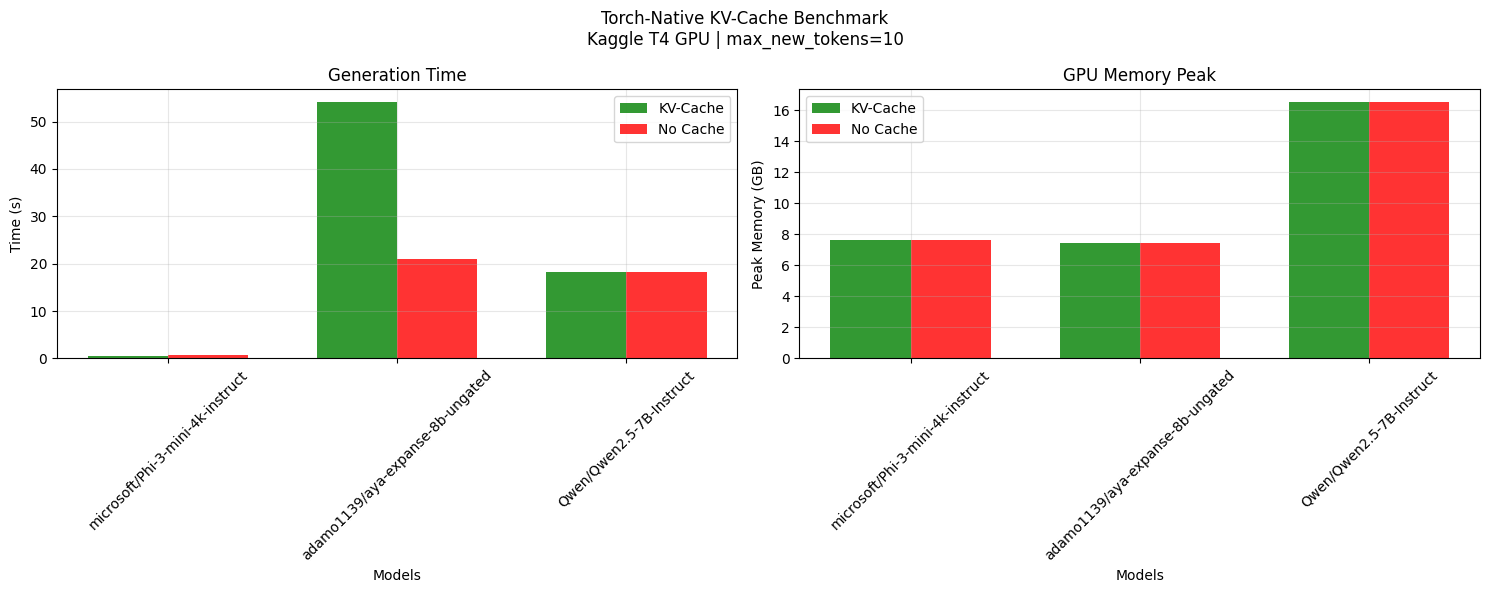

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Your lists (populated by code)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

models = model_names
x = np.arange(len(models))
width = 0.35

# Time plot
ax1.bar(x - width/2, elapsed_times_wtih_cache, width, label='KV-Cache', color='green', alpha=0.8)
ax1.bar(x + width/2, elapsed_times_with_no_cache, width, label='No Cache', color='red', alpha=0.8)
ax1.set_xlabel('Models')
ax1.set_ylabel('Time (s)')
ax1.set_title('Generation Time')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Memory plot
ax2.bar(x - width/2, peaks_with_cache, width, label='KV-Cache', color='green', alpha=0.8)
ax2.bar(x + width/2, peaks_with_no_cache, width, label='No Cache', color='red', alpha=0.8)
ax2.set_xlabel('Models')
ax2.set_ylabel('Peak Memory (GB)')
ax2.set_title('GPU Memory Peak')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Torch-Native KV-Cache Benchmark\nKaggle T4 GPU | max_new_tokens=10')
plt.tight_layout()
plt.savefig('kv_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_767/2218892392.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(models, rotation=45)


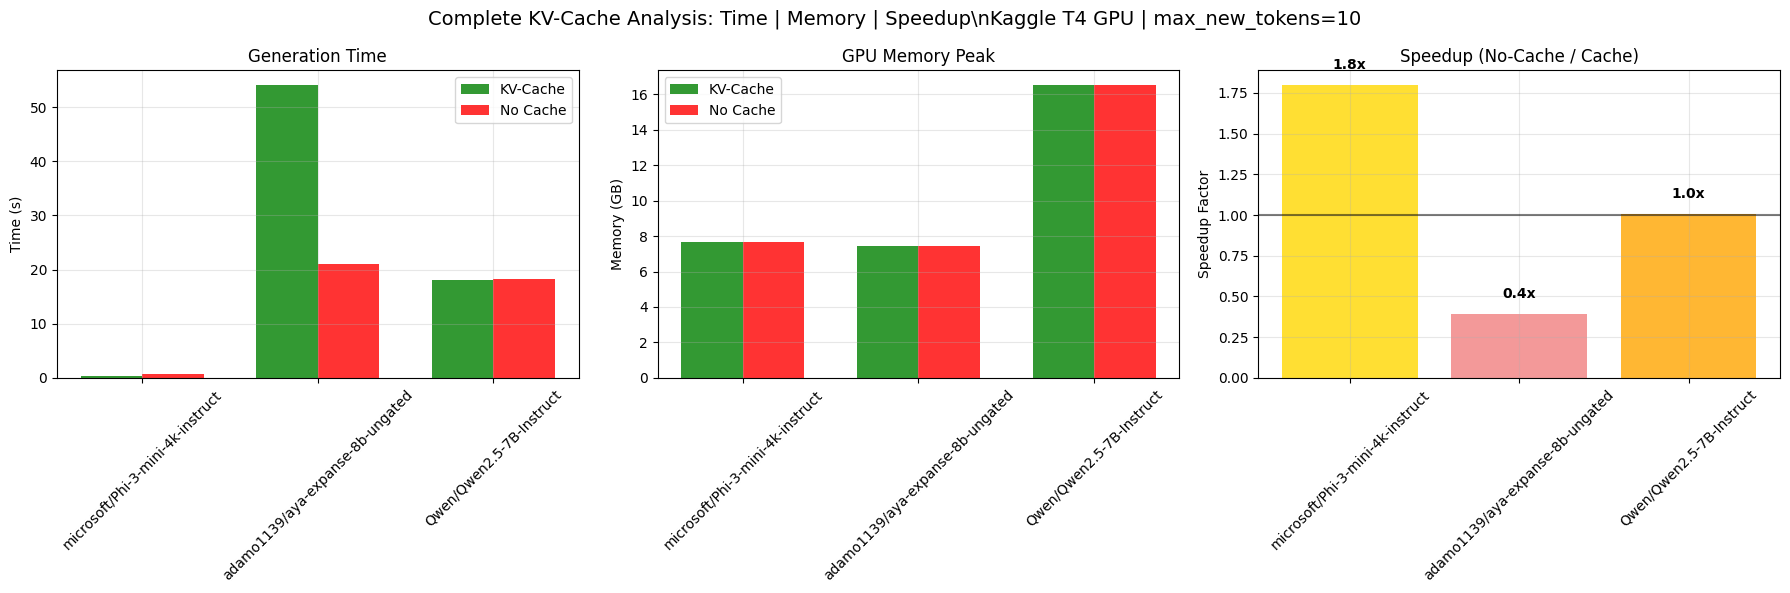

Speedups: {'microsoft/Phi-3-mini-4k-instruct': '1.80x', 'adamo1139/aya-expanse-8b-ungated': '0.39x', 'Qwen/Qwen2.5-7B-Instruct': '1.01x'}


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Speedup subplot (add to your fig)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models = model_names
x = np.arange(len(models))
width = 0.35

# 1. Time
axes[0].bar(x - width/2, elapsed_times_wtih_cache, width, label='KV-Cache', color='green', alpha=0.8)
axes[0].bar(x + width/2, elapsed_times_with_no_cache, width, label='No Cache', color='red', alpha=0.8)
axes[0].set_title('Generation Time')
axes[0].set_ylabel('Time (s)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Memory
axes[1].bar(x - width/2, peaks_with_cache, width, label='KV-Cache', color='green', alpha=0.8)
axes[1].bar(x + width/2, peaks_with_no_cache, width, label='No Cache', color='red', alpha=0.8)
axes[1].set_title('GPU Memory Peak')
axes[1].set_ylabel('Memory (GB)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Speedup (time_no_cache / time_cache)
speedups = [nocache / cache if cache > 0 else 1.0 for cache, nocache in zip(elapsed_times_wtih_cache, elapsed_times_with_no_cache)]
colors = ['gold' if s > 1.5 else 'orange' if s > 1.0 else 'lightcoral' for s in speedups]
axes[2].bar(models, speedups, color=colors, alpha=0.8)
for i, v in enumerate(speedups):
    axes[2].text(i, v + 0.1, f'{v:.1f}x', ha='center', fontweight='bold')
axes[2].set_title('Speedup (No-Cache / Cache)')
axes[2].set_ylabel('Speedup Factor')
axes[2].set_xticklabels(models, rotation=45)
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=1.0, color='black', linestyle='-', alpha=0.5)

plt.suptitle('Complete KV-Cache Analysis: Time | Memory | Speedup\\nKaggle T4 GPU | max_new_tokens=10', fontsize=14)
plt.tight_layout()
plt.savefig('kv_full_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Speedups:", dict(zip(models, [f'{s:.2f}x' for s in speedups])))
